In [1]:
%load_ext autoreload
%autoreload 2
from pbjam.modeID import modeIDsampler
from pbjam import IO
from matplotlib.pyplot import *
import pbjam.distributions as dist
import pandas as pd
import numpy as np
import jax.numpy as jnp

In [2]:
psd = IO.psd('KIC10963065', lk_kwargs={'quarter': (6), 'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})

psd()

f = psd.freq[::2]

s = psd.powerdensity[::2]

Using cached search result.
Loading fits files from cache.


In [3]:
addPriors = {'p_L0': dist.uniform(loc=-2.1, scale=1.1),
             'p_D0': dist.uniform(loc=-2.1, scale=1.1),
             'DPi0': dist.uniform(loc=-2.1, scale=1.1),
             'eps_g': dist.uniform(loc=-2.1, scale=1.1),
             'd01': dist.uniform(loc=-2.1, scale=1.1),
             'H1_nu': dist.uniform(loc=-2.1, scale=1.1),
             'H1_exp': dist.uniform(loc=-2.1, scale=1.1),
             'H_power': dist.uniform(loc=-2.1, scale=1.1),
             'H2_nu': dist.uniform(loc=-2.1, scale=1.1),
             'H2_exp': dist.uniform(loc=-2.1, scale=1.1),
             'alpha_g': dist.uniform(loc=-2.1, scale=1.1),
             'dnu': dist.uniform(loc=-2.1, scale=1.1),
             'd02': dist.uniform(loc=-2.1, scale=1.1),
             'alpha_p': dist.uniform(loc=-2.1, scale=1.1),
             'env_width': dist.uniform(loc=-2.1, scale=1.1),
             'env_height': dist.uniform(loc=-2.1, scale=1.1),
             'mode_width': dist.uniform(loc=-2.1, scale=1.1),
             'teff': dist.uniform(loc=-2.1, scale=1.1),
             'bp_rp': dist.uniform(loc=-2.1, scale=1.1),
             'inc': dist.uniform(loc=-2.1, scale=1.1),
             'nurot_c': dist.uniform(loc=-2.1, scale=1.1) # Core rotation rate in log(muHz)
            }

In [16]:
addObs = {'numax': (10**2.92066686856034, 100),
          'dnu'  : (10**1.69339670499238, 0.54),
          'teff' : (10**3.75135609972539, 77),
          'bp_rp': (0.858788967132568, 0.05),
          }

# {'numax': (10**3.07572399416254, 100),
#           'dnu'  : (10**1.78265858356021, 0.54),
#           'teff' : (10**3.76387703149565, 77),
#           'bp_rp': (0.87506103515625, 0.05),
#           }
 

In [37]:
def plotEigenVectors(ax, m, mu=None, stretch=[1,1], scale=1, labels=[r'$\theta_1$', r'$\theta_2$'], fc=['C1', 'C2'], ec=['C1', 'C2'], linestyles=['-', '-']):

    c = np.cov(m.T)

    eigvals, eigvecs = np.linalg.eig(c)
    
    if mu is None:
        mu = np.mean(m, axis=0)[::-1]
    
    _mu = np.vstack((mu, mu)).T
        
    # Force the first eigenvector to be the longest
    eigvecs[0] *= np.sqrt(eigvals[1])

    eigvecs[1] *= np.sqrt(eigvals[0])
    
    eigvecs = eigvecs[np.argsort(eigvals)]
       
    if all(np.sign(eigvecs[0]) == [ -1, 1]) or all(np.sign(eigvecs[0]) == [ -1, -1]):
        
        eigvecs[0] *=  np.array([-1, -1])
        
    if all(np.sign(eigvecs[1]) == [ 1, -1]) or all(np.sign(eigvecs[1]) == [ -1, -1]):
        eigvecs[1] *=  np.array([-1, -1])
 
    ax.quiver(*_mu, eigvecs[:,0]*stretch[0], eigvecs[:,1]*stretch[1], angles='xy', scale_units='xy', scale=scale, ls=linestyles, linewidth=1, fc=fc, ec=ec)

    #ax.axis('equal');

In [18]:
addObs

{'numax': (833.0419434237732, 100),
 'dnu': (49.36244978986883, 0.54),
 'teff': (5640.999999999954, 77),
 'bp_rp': (0.858788967132568, 0.05)}

In [23]:
N_p = 7

N_pca = 2000

PCAdims = 2
 
Msmall = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=10, PCAdims=PCAdims, priorpath=IO.get_priorpath())
Mbig   = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=200, PCAdims=PCAdims, priorpath=IO.get_priorpath())

In [21]:

pdata = pd.read_csv('/home/nielsemb/work/repos/PBjam/pbjam/data/prior_data.csv', usecols=Msmall.DR.pcalabels)

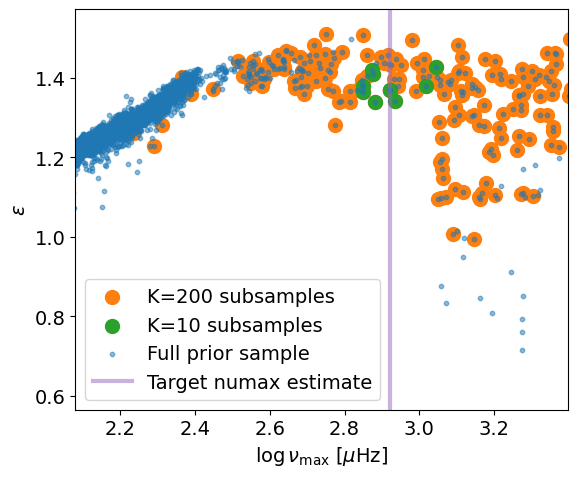

In [250]:
rcParams['font.size'] = 14
fig, ax = subplots(figsize=(6,5))
ax.scatter(Mbig.DR.data_F[:, 0], Mbig.DR.data_F[:, 1], s = 100, color='C1', label=f'K={len(Mbig.DR.data_F[:, 0])} subsamples')
ax.scatter(Msmall.DR.data_F[:, 0], Msmall.DR.data_F[:, 1], s = 100, color='C2', label=f'K={len(Msmall.DR.data_F[:, 0])} subsamples')
ax.scatter(pdata['numax'], pdata['eps_p'], c='C0', s = 10, alpha=0.5, label='Full prior sample')

idx = pdata['numax'] > np.log10(150)

# left, bottom, width, height = [0.15, 0.185, 0.4, 0.4]
# ax2 = fig.add_axes([left, bottom, width, height])

# plotEigenVectors(ax2, Mbig.DR.data_F[:,::-1], fc=['C1', 'C1'], ec=['C1', 'C1'], mu=[0, 0], scale=1)
# plotEigenVectors(ax2, Msmall.DR.data_F[:,::-1], fc=['C2', 'C2'], ec=['C2', 'C2'], mu=[0, 0], scale=1)
# plotEigenVectors(ax2, pdata.loc[idx, ['numax', 'eps_p']].values[:,::-1], fc=['C0', 'C0'], ec=['C0', 'C0'], mu=[0, 0], stretch=[0.5, 1])
# ax2.set_xlim(-0.05, 0.35)
# ax2.set_ylim(-0.05, 0.15)
# ax2.axvline(0, color='k', ls='dashed', lw=1, alpha=0.5)
# ax2.axhline(0, color='k', ls='dashed', lw=1, alpha=0.5)

# ax2.text(0.04, 0.12, s='Sample eigenvectors')
# ax2.set_yticks([])
# ax2.set_xticks([])


ax.set_xlabel(r'$\log \nu_{\mathrm{max}}$ [$\mu$Hz]')
ax.set_ylabel('$\epsilon$')
ax.set_xlim(np.log10(120), np.log10(2500))
ax.axvline(np.log10(addObs['numax'][0]), lw=3, alpha=0.5, label='Target numax estimate', color='C4')
ax.legend(loc=3)
fig.tight_layout()
fig.savefig('pca_selection.png', dpi=300)

In [ ]:
np.cov( Msmall.DR.data_F.T)


In [ ]:
np.array([[1,2,3], [2,3,4]])[::-1].shape#.T

In [ ]:
fig, ax = subplots()
#plotEigenVectors(ax, Mbig.DR.data_F.T)

ax.scatter(pdata['numax'], pdata['eps_p'], c='C0', s = 10, alpha=0.5, label='Total sample')

ax.scatter(Mbig.DR.data_F[:, 0], Mbig.DR.data_F[:, 1], s = 100, color='C1', label=f'K={len(Mbig.DR.data_F[:, 0])}')

ax.scatter(Msmall.DR.data_F[:, 0], Msmall.DR.data_F[:, 1], s = 100, color='C2', label=f'K={len(Msmall.DR.data_F[:, 0])}')


plotEigenVectors(ax, Mbig.DR.data_F[:,::-1])
plotEigenVectors(ax, Msmall.DR.data_F[:,::-1])
plotEigenVectors(ax, pdata.loc[idx, ['numax', 'eps_p']].values[:,::-1])

#plotEigenVectors(ax, pdata[['numax', 'eps_p']].values.T)

In [ ]:
big_samples_eigs = M.DR.eigvectors.copy()

In [ ]:
import jax.numpy as jnp
small_samples_eigs = jnp.array([0.38506192+0.j, 1.65575441+0.j])

In [ ]:
small_samples_eigs

In [ ]:
fig, ax = subplots(figsize=(6,5))
ax.plot([0, small_samples_eigs[0,0]], [0, small_samples_eigs[1,0]], color='C1')
ax.plot([0, small_samples_eigs[0,1]], [0, small_samples_eigs[1,1]], color='C1')
ax.set_xlim(-1,1)
ax.set_ylim(-0.1,1)
ax.axis('equal')

In [ ]:
M.DR.eigvectors

In [ ]:
import corner

In [ ]:
corner.corner(pdata[['numax', 'dnu', 'eps_p']])

In [ ]:
np.log10(500)

In [ ]:
from pbjam.modeID import modeIDsampler
from pbjam import IO
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from matplotlib.pyplot import *
import astropy.convolution as conv

In [ ]:
jax.config.update('jax_enable_x64', True)

In [ ]:
psd = IO.psd('KIC5184732', lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})

In [ ]:
psd()

In [ ]:
# obs = {'numax': (10**3.34222494336567, 5),
#        'dnu': (10**2.01810676416183, 0.54),
#        'd02': (10**0.68977840189176, 0.54),
#        'teff': (10**3.76117581315573, 142), 
#        'bp_rp': (0.86, 0.05),
#        'p_L0'        : 4e-10, 
#        'p_D0'        : 6e-10, 
#        'DPi0'       : 0.5,  #1/muHz
#        'eps_g'      : 0.75, 
#        'alpha_g'    : 0.02} 

obs = {'numax'  : (2140, 5),
       'dnu'    : (96.00, 0.54),
       'd02'    : (0.90, 0.54),
       'teff'   : (5842, 142), 
       'bp_rp'  : (0.83, 0.05),
       'p_L0'   : 4e-10, 
       'p_D0'   : 6e-10, 
       'DPi0'   : 0.5,  #1/muHz
       'eps_g'  : 0.75, 
       'alpha_g': 0.02} 

priorpath = IO.get_priorpath()

In [ ]:
M = modeIDsampler(psd.freq, psd.powerdensity, obs, 7, priorpath=priorpath, Npca=7, PCAdims=14, freq_limits=[1,8500])

In [ ]:
fac = max([1, 0.5 / (M.f[1] - M.f[0])])
kernel = conv.Gaussian1DKernel(stddev=np.array(fac))
smoo = conv.convolve(M.s, kernel)

In [ ]:
N = 20

fig, ax = subplots(figsize=(16,9))

ax.loglog(M.f, smoo)

for i in range(N):
    u = np.random.uniform(0, 1, size=M.ndims)

    theta = M.ptform(u)

    theta_u = M.unpackParams(theta)

    m = M.model(theta_u, M.f)
    
    ax.loglog(M.f[M.sel], m[M.sel], alpha = 0.2)
    

In [ ]:
sampler, samples = M()

In [ ]:
fig, ax = subplots(figsize=(16,9))
ax.plot(M.f, smoo)
#ax.set_xlim(1000, 2500)
#ax.set_ylim(0, 20)
N = 10
for i in np.random.randint(0, samples.shape[0], size=N):
    
    theta = samples[i, :]

    theta_u = M.unpackParams(theta)
    print(theta_u['numax'])
    m = M.model(theta_u, M.f)
    
    ax.plot(M.f, m, color='C3', alpha=0.25)
    
ax.set_yscale('log')
ax.set_xscale('log')

In [ ]:
fig, ax = subplots(figsize=(16,9))
ax.plot(M.f, smoo/m)

In [ ]:
df = pd.read_csv('pbjam/data/prior_data.csv')

In [ ]:
#scatter(np.log10(obs['numax'][0]), np.log10(obs['dnu'][0]), color='C3')
scatter(df['numax'], df['H2_power'], c='C0')
scatter(df['numax'], df['H1_power'], c='C1')

#scatter(M.DR.data_F[:, 1], M.DR.data_F[:, 0], c='C1')
#xlim(3.2, 3.5)
#ylim(1.9, 2.1)

In [ ]:
df['ID'].values[(3.2 < df['numax']) & (df['numax'] < 3.25)]

In [ ]:
key = 'shot'
x = np.linspace(M.priors[key].ppf(1e-3), M.priors[key].ppf(1-1e-3), 100)
fig, ax= subplots()
ax.plot(x, M.priors[key].pdf(x))

In [ ]:
fig = corner.corner(np.array(M.DR.data_R), hist_args={'density': True})
ax = fig.get_axes()
ax = np.array(ax).reshape((M.PCAdims, M.PCAdims))

for i, key in enumerate(list(M.priors.keys())[:M.PCAdims]):
    x = np.linspace(M.priors[key].ppf(1e-3), M.priors[key].ppf(1-1e-3), 100)
    ax[i,i].plot(x, M.priors[key].pdf(x))

In [ ]:
M.PCAdim

In [ ]:
theta_u = M.unpackParams(theta)

In [ ]:
df = pd.read_csv('pbjam/data/prior_data.csv')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.scatter(df['H1_exp'], df['H2_exp'], s = 5, alpha=0.5)
#ax.scatter(M.DR.data_F[:, 1], M.DR.data_F[:, 5])

#ax.set_xlim(500,2300)
#ax.set_ylim(0, 7500)
#ax.set_yscale('log')
#ax.set_xscale('log')
#plt.scatter(df['numax'], df['H3_power'])

In [ ]:
numax_idx = np.argsort(df['numax'])

In [ ]:
v = df['ID'][numax_idx].values

In [ ]:
v[-10:]

In [ ]:
import matplotlib.pyplot as plt
plt.loglog(M.f, M.model(theta_u, M.f))

In [ ]:
S = unpackSamples(M, samples)

In [ ]:
import corner
corner.corner(S);

In [ ]:
from pbjam.jar import constants as c
from pbjam.jar import scalingRelations as sr
from pbjam.detection import detect
from pbjam import jar
import jax.scipy.special as jsc
from time import time

f, p = psd.freq, psd.powerdensity
 
dilution = 1   

maskPoints = [] # extras.getMaskPoints(ID, artefactListPath)

# PDP_D_122_TEFF_SAPP
Teff = obs['teff'][0]

# PDP_C_125_CLASSICAL_RADIUS.
R = 1.5 # tgtList.loc[k, 'radius']


# t1 = time()
# PEdetected = PE()
# print(time()-t1)

In [ ]:
DT = detect(f, p, Teff=Teff, Radius=R, Bin_width=1, dilution=dilution, maskPoints=maskPoints)

In [ ]:
DT()

In [ ]:
plot(DT.fb, DT.merit)

In [ ]:
 # Compute the detection flag using the power excess method (MSAP3_01A)
PE  = PEDetection(f, p, Teff=Teff, Radius=R, Bin_width=1, dilution=dilution, maskPoints=maskPoints)

PE1 = PEDetection(f, p, Teff=Teff, Radius=R, Bin_width=1, dilution=dilution, maskPoints=maskPoints)


# PEdetected = PE1()


In [ ]:
t1 = time()
PE.numaxLogProbability()
print(time()-t1)

In [ ]:
t1 = time()
PE1._numaxLogProbability()
print(time()-t1)

In [ ]:
PE.PH1, PE.PH1marg = PE.computePosterior(zeronan=True)
PE.merit = PE.PH1marg

In [ ]:
PE1.PH1, PE1.PH1marg = PE1._computePosterior(zeronan=True)
PE1.merit = PE1.PH1marg

In [ ]:
plot(PE.fb, PE.merit) 
plot(PE1.fb, PE1.merit) 


In [ ]:
type(PE1.FA)

In [ ]:
PE1._thresholdPrior(PE1.SNRPred)

In [ ]:
@jax.jit
def chi2logsf(x, df, scale):
    return jnp.log(chi2sf(x, df, scale))  

FA=np.array(PE1.FA)
dof = np.array(PE1.dof)
SNRP = np.array(PE1.SNRPred)
#np.array([chi2logsf(PE1.FA[dof]/(1+PE1.SNRPred[i, :]), df=dof, scale=1./dof) for i, dof in enumerate(PE1.dof)])
        

In [ ]:
W = sr.envWidth(PE1.fb) / (2*jnp.sqrt(2*jnp.log(2)))

sumRange = 1.5 * W  + PE1.dfb


In [ ]:
dof

In [ ]:
@jax.jit
def test(a, idx):
    return a[idx] 
a= jnp.array([1,1,1,1])
idx = jnp.array([True, True, True, True])
test(a, idx)

In [ ]:
idx = jnp.array([True]*61, dtype=bool)

PE1.test(idx)

In [ ]:
PE.PH1, PE.PH1marg = PE.computePosterior(zeronan=True)
PE.merit = PE.PH1marg

In [ ]:
PE1.PH1, PE1.PH1marg = PE1.computePosterior(zeronan=True)
PE1.merit = PE1.PH1marg

In [ ]:
plot(PE.fb, PE.merit) 
plot(PE1.fb, PE1.merit, alpha = 0.5) 

In [ ]:
from copy import deepcopy

PE2 = deepcopy(PE)

In [ ]:
@jax.jit
def chi2logpdf(x, df, scale):
    """ Compute log prob of chi2 dist.

    If normed=True this is equivalent to using the scipy.stats chi2 as
    chi2.logpdf(x, df=df, loc=0, scale=scale)

    If normed=False the normalization to unit area is discarded to speed
    up the computation. This is a fudge for using this with MCMC etc.

    Parameters
    ----------
    x : array
        Points at which to evaluate the log-pdf
    df : int
        Degrees of freedom of the chi2 distribution
    scale : float
        Scale factor for the pdf. Same as the scale parameter in the
        scipy.stats.chi2 implementation.

    Returns
    -------
    logpdf : array
        Log of the pdf of a chi^2 distribution with df degrees of freedom.

    """

    x = x.T / scale
 
    return -(df/2)*jnp.log(2) - jsc.gammaln(df/2) - x/2 - jnp.log(scale) + jnp.log(x)*(df/2-1)
 
     
@jax.jit
def chi2sf(x, df, scale):
    return jsc.gammaincc(df/2, x/scale/2)

@jax.jit
def chi2logsf(x, df, scale):
    return jnp.log(chi2sf(x, df, scale))  

# Loop over all test frequencies
#@jax.jit
def numaxLogProbability(self, Nsig=5): 
    
    # The numax prior and the H0 probabilities are independent of the
    # predicted envelope amplitude (no marginalization), so we compute
    # these first to get them out of the way. Note the scaling of the
    # width to 1.5*sigma
    W = sr.envWidth(self.fb) / (2*jnp.sqrt(2*jnp.log(2)))
    sumRange = 1.5 * W  + self.dfb
    
    # We assume that the envelope amplitude at numax, Amax, generally
    # follows the scaling relation given by muAmax, but with some
    # scatter around it given by sigmaAmax, and that the scatter in
    # true values of Amax are symmetric around log(Amax) from the
    # scaling relations, and roughly Gaussian.
    muAmax = jnp.log10(sr.Amax(self.fb, self.Teff))

    # Define the range of amplitudes to try out (integrate over). This
    # is centered on muAmax with a spread of 2*Nsig*sigmaAmax. Here Nsig
    # determines the number of sigma the amplitude range should span.
    Amax_error = jnp.linspace(-Nsig * self.sigmaAmax, Nsig * self.sigmaAmax, self.Nint)
    self.Amax =  muAmax[:, None] + Amax_error

    #fac = 10**(2*Amax_error)
    def test(idx):
    
        btot = jnp.trapz(self.bb[idx], dx=self.dfb)

        ptot = jnp.trapz(self.pb[idx], dx=self.dfb) - btot

        return self.fb[idx][0], self.fb[idx][-1], (len(self.fb[idx]) + 1)*2*self.Nbin, ptot, btot

    M, N, self.dof, Ptot, Btot = jnp.array([test(abs(self.fb-self.fb[i]) < sumRange[i]) for i in range(len(self.fb))]).T
 
    #     M, N = np.array([f[abs(f-f[i]) <= sumRange[i]][jnp.asarray([0, -1])] for i in range(len(self.fb))]).T

    #     Btot = jnp.array([jnp.trapz(self.bb[(M[i] <= self.fb) & (self.fb <= N[i])], dx=self.dfb) for i in range(len(self.fb))])

    #     Ptot = jnp.array([jnp.trapz(self.pb[(M[i] <= self.fb) & (self.fb <= N[i])], dx=self.dfb) - Btot[i] for i in range(len(self.fb))])

    #     self.dof = 2 * jnp.array([len(self.pb[(M[i] <= self.fb) & (self.fb <= N[i])]) for i in range(len(self.fb))]) * self.Nbin + 2*self.Nbin

    self.SNR = Ptot / Btot 
     
    eta = jar.attenuation(self.fb, self.Nyquist)

    Henv = sr.envHeight(10**self.Amax.T, self.V, self.dilution, eta, numax=self.fb)

    PtotPred = jnp.sqrt(jnp.pi/2) * Henv * W * (jax.lax.erf((self.fb - M)/(jnp.sqrt(2)*W)) - 
                                                jax.lax.erf((self.fb - N)/(jnp.sqrt(2)*W)))
     
    # Compute the predicted SNR
    self.SNRPred = PtotPred.T / Btot[:, None]

    # The weights are assumed to be Gaussian distributed around muAmax.
    # The normalization can probably be computed outside the loop to
    # speed things a bit? Also This could potentially be turned into log-wA
    # to get rid of the exp call.
    self.logProbabilities['wA'] = jar.normal(self.Amax.T, muAmax, self.sigmaAmax) 
        
    # Compute the probability of numax given photometric constraints.
    self.logProbabilities['numaxObs'] = self.logNumaxPrior(self.fb, self.numax_guess, self.sigmaNumax).repeat(self.Nint).reshape((len(self.fb), self.Nint))
    
    # Compute the H0 probability. Can maybe use chi2.logsf instead?
    self.logProbabilities['H0'] = chi2logpdf(1 + self.SNR, df=self.dof, scale=1./self.dof).T # scalar -> array
    
    # Compute the H1 likelihood.
    print(self.SNR[:, None].shape)
    print(self.SNRPred.shape)
    print(self.dof.shape)
    self.logProbabilities['H1'] = chi2logpdf((1 + self.SNR[:, None]) / (1 + self.SNRPred), df=self.dof, scale=1./self.dof).T

    # Compute the false alarm (threshold) probability
    self.logProbabilities['falseAlarm'] = self._thresholdPrior(self.SNRPred, self.dof)

In [ ]:
PE1.logProbabilities['falseAlarm'] = PE1._thresholdPrior(PE1.SNRPred, PE1.dof)

In [ ]:
PE1._numaxLogProbability()

In [ ]:
numaxLogProbability(PE1)

In [ ]:
plot(PE2.logProbabilities['H1'][:, 11])
plot(PE.logProbabilities['H1'][:, 11])
xlim(0, 1000)

In [ ]:
def thresholdPrior(self, SNRPred, dof):
    """ Computes the false alarm probability prior

    Estimates where we can be reasonably sure that the predicted p-modes
    will be visible, given the observed background. This is then used as a
    prior.

    Parameters
    ----------
    SNRPred : array
        Array of predicted SNR values in the spectrum (Ptot_pred/Btot).
    dof : int
        Degress of freedom of the chi^2 distribution

    Returns
    -------
    logp_thresh : array
        The log of the threshold prior at each frequency.
    """

    # Find the value of x corresponding to a false alarm probability
    SNRThresh = self.FA[dof.astype(int)-1]
  
    # False alarm (threshold) prior   
    logp_thresh = chi2logsf(SNRThresh[:, None]/(1+SNRPred), df=dof[:, None], scale=1./dof[:, None])
     
    return logp_thresh 

In [ ]:
_T = thresholdPrior(PE2, PE2.SNRPred, PE2.dof)

In [ ]:
n = 0
plot(PE.fb, _T)
plot(PE.fb, PE.logProbabilities['falseAlarm'])
 

In [ ]:
PE2.FA[PE2.dof.astype(int)-1][:, None] /(1+PE2.SNRPred)

In [ ]:
PE2.SNRPred

In [ ]:
PE.SNRPred

In [ ]:
eta = jar.attenuation(PE.fb, PE.Nyquist)

W = sr.envWidth(PE.fb) / (2*jnp.sqrt(2*jnp.log(2)))

sumRange = 1.5 * W  + PE.dfb

M = np.maximum(PE.fb[0], PE.fb - sumRange)
    
N = np.minimum(PE.fb[-1], PE.fb + sumRange)

i = 600

fig, ax = subplots()
for i in np.arange(1, len(PE.fb), 100):
    Henv = sr.envHeight(10**PE.Amax.T[11, i], PE.V, PE.dilution, eta[i], numax=PE.fb[i])

    
    mu = PE.fb[i]
    _P = jnp.sqrt(jnp.pi/2) * Henv * W[i] * (jax.lax.erf((mu - M[i])/(jnp.sqrt(2)*W[i])) - 
                                             jax.lax.erf((mu - N[i])/(jnp.sqrt(2)*W[i])))


    envelope = jar.gaussian(PE.fb, Henv, mu, W[i])
    _E = jnp.trapz(envelope[(M[i] < PE.fb) & (PE.fb < N[i])], dx=PE.dfb)
    
    ax.plot(i,_P / _E, '.', color='C0')
    
    #ax.plot(i,, '.', color='C1')

In [ ]:
PtotPred 

In [ ]:
jnp.sum(envelope[(M[i] < PE.fb) & (PE.fb < N[i])])  

In [ ]:
plot(PE.fb, envelope)

In [ ]:
from pbjam import jar
#from jar.scalingRelations import envWidth

In [ ]:
widths = 1.5 * jar.scalingRelations.envWidth(PE2.fb) / (2*jnp.sqrt(2*jnp.log(2)))
nu = PE2.fb[2000]
envRange = abs(PE2.fb - nu) < (widths[2000] + PE2.dfb)
env = PE2.pmode_env(PE2.fb[envRange], nu, PE2.Teff)

In [ ]:

f = PE.fb

sumRange = 1.5 * sr.envWidth(f) / (2*jnp.sqrt(2*jnp.log(2)))  + PE.dfb
 
M = jnp.maximum(f[0], f[np.array([np.argmin(abs(f - sumRange))])

N = jnp.minimum(f[-1], f + sumRange)

m, n = np.zeros(len(f)), np.zeros(len(f))

for i, nu in enumerate(f[:10]):
          
    envRange = abs(f-nu) <= sumRange[i]
    
    m[i] = f[envRange][0]
    n[i] = f[envRange][-1]

In [ ]:
from time import time

In [ ]:
t1 = time()

M, N = np.array([[f[abs(f-f[i]) <= sumRange[i]][0],f[abs(f-f[i]) <= sumRange[i]][-1]] for i in range(5000)]).T
print(time()-t1)

In [ ]:
t1 = time()
M = np.array([f[abs(f-f[i]) <= sumRange[i]][0] for i in range(10)])
N = np.array([f[abs(f-f[i]) <= sumRange[i]][-1] for i in range(10)])
print(time()-t1)

In [ ]:
t1 = time()
print(time()-t1)

In [ ]:
18.080202102661133*8.55

In [ ]:
plot(PE.fb[:10], M[:10], color='C0')
plot(PE.fb[:10], N[:10], color='C1')

plot(PE.fb[:10], m[:10], color='C0', ls='dashed')
plot(PE.fb[:10], n[:10], color='C1', ls='dashed')

In [ ]:
fig, ax = subplots(figsize=(16,9))
ax.plot(PE.fb[:10], (M[:10]-m[:10]),'.', color='C0')
#ax.plot(PE.fb[:10], (N[:10]-n[:10])/PE.dfb,'.', color='C1')

 

In [ ]:
PE.f[2]

In [ ]:
1.7158631181105715-2.044256835273273

In [ ]:
4.694111244545349-4.751170817196442

In [ ]:
10.650607497414905-11.289511486845495

In [ ]:
W = sr.envWidth(PE.fb, PE.Teff) / (2*jnp.sqrt(2*jnp.log(2)))
sumRange = 1.5 * W  + PE.dfb

llim = np.maximum(PE.fb[0], PE.fb - sumRange)
    
ulim = np.minimum(PE.fb[-1], PE.fb + sumRange)

envRange = abs(PE.fb[:, None] - PE.fb) < sumRange

for i in range(len(PE.fb))[:10]:
    
    envRange = abs(PE.fb - PE.fb[i]) < sumRange[i]
    print(PE.fb[envRange])
    print(PE.fb[envRange][0], PE.fb[np.argmin(abs(PE.fb - llim[i]))])
    print(PE.fb[envRange][-1], PE.fb[np.argmin(abs(PE.fb - ulim[i]))])
    print()

#(M[i-1] < self.fb) & (self.fb < N[i])

In [ ]:
envRange = abs(PE.fb[:, None] - PE.fb) < (widths[:, None] + PE.dfb)

In [ ]:
numaxLogProbability(PE1, Nsig=5)

In [ ]:
plot(PE0.fb, PE0.merit) 

In [ ]:
import jax.scipy.special as jsc
import scipy.special as sc

In [ ]:
from scipy.stats import chi2

In [ ]:
x = np.ones(10)
dof = 2
scale=1/dof
chi2.logsf(x, df=dof, scale=scale)

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/home/nielsemb/work/Projects/priorBuilder/prior_data.csv')

In [ ]:
from matplotlib.pyplot import *

In [ ]:
scatter(10**df['teff'], df['eps_p'])
y = -0.00080 * 10**df['teff'] + 6.3
plot(10**df['teff'], y)

idx = df['eps_p'] > y

scatter(10**df['teff'][idx], df['eps_p'][idx])

ylim(0.5, 1.7)
xlim(6000, 7000)
# xscale('#log')
#yscale('log')

In [ ]:
df[idx]

In [ ]:
fig, ax = subplots(figsize = (16,24))
ax.scatter(df['dnu'], df['d02'], alpha=0.5, s=5)
#ax.set_xlim(1.5, 6)
#ax.set_ylim(1.5, 6)
# y = -1 * df['numax']  + 5.5
# idxH = df['H_power'] < y
# ax.plot(df['numax'], y )

In [ ]:
df.to_csv('/home/nielsemb/work/Projects/priorBuilder/prior_data.csv', index=True)

In [ ]:
df[idx]

In [ ]:
scatter(df['numax'], df['d02'])
xlim(2.4, 3.6)
ylim(0.2, 1.2)
# ylim(25, 30)

In [ ]:
np.log10(284)

In [ ]:
tgtList = pd.read_csv('/home/nielsemb/work/Projects/priorBuilder/tgtList.csv')
tgtList.sort_values('teff', inplace=True, ignore_index=True)

In [ ]:
tgtList

In [ ]:
done = ['KIC8228742',
        'KIC8179536',
        'KIC7510397',
        'KIC7106245',
        'KIC2837475',
        'KIC3643774',
        'KIC4586099',
        'KIC7206837',
        'KIC7771282',
        'KIC9812850',
        'KIC11253226',
        'KIC1435467',
        'KIC3427720',
        'KIC3656476',
        'KIC3735871',
        'KIC4554810',
        'KIC5184732',
        'KIC6116048',
        'KIC6603624',
        'KIC6933899',
        'KIC7106245',
        'KIC7510397',
        'KIC7680114',
        'KIC7871531',
        'KIC7970740',
        'KIC8006161',
        'KIC8150065',
        'KIC8179536',
        'KIC8228742',
        'KIC8394589',
        'KIC8424992',
        'KIC8694723',
        'KIC8938364',
        'KIC9025370',
        'KIC9098294',
        'KIC9139151',
        'KIC9289275',
        'KIC9410862',
        'KIC9693187',
        ]

In [ ]:
for kic in done:
    
    if kic in tgtList.loc[:, 'ID'].values:
        print(kic) 
#         idx = tgtList.loc[:, 'ID'] == kic
        
#         tgtList.drop(tgtList[idx].index, inplace=True)
        


In [ ]:
tgtList.reset_index(inplace=True)

In [ ]:
tgtList

In [ ]:
tgtList.to_csv('/home/nielsemb/work/Projects/priorBuilder/tgtList.csv', index=False)

In [ ]:
def plotEigenVectors(ax, m, mu=None, stretch=[1,1], labels=[r'$\theta_1$', r'$\theta_2$'], colors=['C1', 'C2'], linestyles=['-', '-']):

    c = np.cov(m.T)

    eigvals, eigvecs = np.linalg.eig(c)
    
    if mu is None:
        mu = np.mean(m, axis=0)
    
    _mu = np.vstack((mu, mu)).T
        
    # Force the first eigenvector to be the longest
    eigvecs[0] *= np.sqrt(eigvals[1])

    eigvecs[1] *= np.sqrt(eigvals[0])
    
    eigvecs = eigvecs[np.argsort(eigvals)]
       
    if all(np.sign(eigvecs[0]) == [ -1, 1]) or all(np.sign(eigvecs[0]) == [ -1, -1]):
        
        eigvecs[0] *=  np.array([-1, -1])
        
    if all(np.sign(eigvecs[1]) == [ 1, -1]) or all(np.sign(eigvecs[1]) == [ -1, -1]):
        eigvecs[1] *=  np.array([-1, -1])
 
    ax.quiver(*_mu, eigvecs[:,0], eigvecs[:,1], angles='xy', scale_units='xy', scale=1, ls=linestyles, linewidth=1, fc=colors, ec='k')

    ax.axis('equal');

In [ ]:
val = np.random.uniform(-0.99, 0.99)

cov = np.array([[1, val], [val, 1]])

mu0 = np.random.uniform(-10, 10, size=2)

m = np.random.multivariate_normal(mu0, cov, 3000)
 
c = np.cov(m.T)

eigvals, eigvecs = np.linalg.eig(c)

eigvecs[0] *= np.sqrt(eigvals[1])

eigvecs[1] *= np.sqrt(eigvals[0])

In [ ]:
 
fig, ax = subplots(figsize=(6,5))
ax.scatter(m[:, 0], m[:, 1])

plotEigenVectors(ax, m)
 



In [102]:
from functools import partial
import jax
import jax.numpy as jnp
class PCA():
    def __init__(self, sample, weights=None, weight_args={}):
        """ Class for handling PCA-based dimensionality reduction

        Parameters
        ----------
        obs : list
            List of observational parameters, e.g., numax, dnu, teff, bp_rp. To 
            be used to find local covariance. Must be in the same units as in 
            the prior sample file.
        pcalabels : list
            List of labels to be used for the PCA. Should probably correspond to
            columns in csv file or you won't get very far.
        fname : str
            Full pathname of the csv file containing the prior sample
        nsamples : int
            Number of neightbors to use.
        weights : object, optional
            Array corresponding to N or callable function to get a list of 
            weights to apply to the data sample, by default None
        weight_args : dict, optional
            Dictionary of arguments if weights is a callable function, empty by 
            default.
        """

         
        self.data_F = sample
        
        self.nsamples, self.dims_F  = sample.shape

        self.setWeights(weights, weight_args)

        self.mu  = jnp.average(self.data_F, axis=0, weights=self.weights)

        self.var = jnp.average((self.data_F-self.mu)**2, axis=0, 
                               weights=self.weights)

        self.std = jnp.sqrt(self.var)

 
    def setWeights(self, w, kwargs):
        """
        Set the PCA weights. If None is given then the weights are uniform.

        Parameters
        ----------
        w : np.array
            Array of weights of length equal to number of samples.
        kwargs : dict
            Dictionary of kwargs for the weight function.
        """
         
        if w is None:
            self.weights = jnp.ones(self.nsamples)

        elif callable(w):
            self.weights = w(self, **kwargs)

        else:
            self.weights = w
 

 

    @partial(jax.jit, static_argnums=(0,))
    def scale(self, data):
 

        scaledData = (data - self.mu) / self.std

        return scaledData

    @partial(jax.jit, static_argnums=(0,))
    def invert_scale(self, scaledData):
 

        unscaled = scaledData * self.std + self.mu

        return unscaled

    @partial(jax.jit, static_argnums=(0,))
    def transform(self, X):
 
        _X = self.scale(X)
         
        Y = self.eigvectors[:, self.sortidx].T.dot(_X.T)

        return Y.T.real

    @partial(jax.jit, static_argnums=(0,))
    def inverse_transform(self, Y):
 

        _X = jnp.dot(Y, self.eigvectors[:, self.sortidx].T)

        return self.invert_scale(_X).real

    def fit_weightedPCA(self, dim):
 

        self.dims_R = dim

        _X = self.scale(self.data_F)
         
        self.covariance = self.covarianceMatrix(_X)
        
        self.eigvals, self.eigvectors = jnp.linalg.eig(self.covariance)

        self.sortidx = sorted(range(len(self.eigvals)), key=lambda i: self.eigvals[i], reverse=True)[:self.dims_R]

        self.explained_variance_ratio = sorted(self.eigvals / jnp.sum(self.eigvals), reverse=True)

        self.erank = jnp.exp(-jnp.sum(self.explained_variance_ratio * np.log(self.explained_variance_ratio))).real

        self.data_R = self.transform(self.data_F)

    def covarianceMatrix(self, _X):


        W = jnp.diag(self.weights)
        
        C = _X.T@W@_X * jnp.sum(self.weights) / (jnp.sum(self.weights)**2 - jnp.sum(self.weights**2))

        return C


Example 1

In [195]:
y1 = np.random.multivariate_normal(np.array([0, 3]), np.array([[1, 0], [0, 1]]), size=1000)
y2 = np.random.multivariate_normal(np.array([0, -3]), np.array([[1, 0], [0, 1]]), size=1000)

E1 = np.vstack((y1,y2))

In [107]:
import pbjam.distributions as dist

In [197]:
ndim = 2

E1P = PCA(E1)

E1P.fit_weightedPCA(ndim)

_Y = E1P.transform(E1P.data_F)

E1P.ppf, E1P.pdf, E1P.logpdf, E1P.cdf = dist.getQuantileFuncs(_Y)

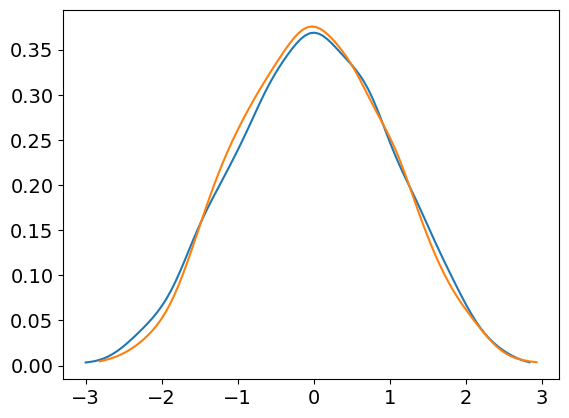

In [202]:
x = np.linspace(E1P.ppf[0](1e-3), E1P.ppf[0](1-1e-3), 100)
plot(x, E1P.pdf[0](x))

x = np.linspace(E1P.ppf[1](1e-3), E1P.ppf[1](1-1e-3), 100)
plot(x, E1P.pdf[1](x))

In [205]:
def ptform(u, ppf):
       
    theta = np.array([ppf[i](u[i]) for i in range(ndim)])

    return theta

In [213]:
def lnlikelihood(theta):
 
    lnlike = np.sum(theta)**2
        
    return lnlike**1e-7

In [216]:
import dynesty 
from dynesty import utils as dyfunc

nlive=100

sampler = dynesty.DynamicNestedSampler(lnlikelihood, 
                                       ptform, ndim, nlive=nlive, sample='rwalk', ptform_args=[E1P.ppf])
            
sampler.run_nested(print_progress=True, wt_kwargs={'pfrac': 1.0},  dlogz_init=1e-3 * (nlive - 1) + 0.01, nlive_init=nlive)  
            
result = sampler.results

unweighted_samples, weights = result.samples, jnp.exp(result.logwt - result.logz[-1])

samples = dyfunc.resample_equal(unweighted_samples, weights)

E1P_samples = E1P.inverse_transform(samples)

10048it [00:06, 1596.10it/s, batch: 93 | bound: 0 | nc: 1 | ncall: 10758 | eff(%): 93.400 | loglstar:   -inf <  1.000 <  1.000 | logz:  1.000 +/-  0.000 | stop:  0.996]     


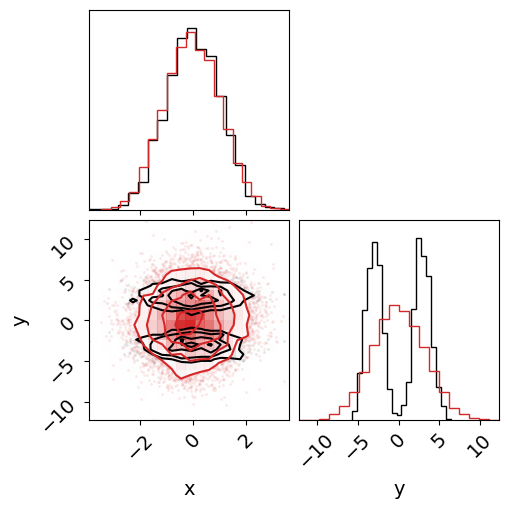

In [243]:
fig = corner.corner(E1, hist_kwargs={'density': True})
corner.corner(np.array(E1P_samples), color='C3', fig=fig, labels=['x', 'y'], hist_kwargs={'density': True})
fig.savefig('two_modes.png')

Example 2

In [98]:
y1 = np.random.multivariate_normal(np.array([0,  2]), np.array([[1, 0], [0, 0.1]]), size=1000)
y2 = np.random.multivariate_normal(np.array([2,  0]), np.array([[1, 0], [0, 0.1]]), size=1000)
y3 = np.random.multivariate_normal(np.array([4, -2]), np.array([[1, 0], [0, 0.1]]), size=1000)

E2 = np.vstack((y1,y2,y3))

In [226]:
ndim = 2
E2P = PCA(E2)

E2P.fit_weightedPCA(ndim)

E2P.ppf, E2P.pdf, E2P.logpdf, E2P.cdf = dist.getQuantileFuncs(E2P.transform(E2P.data_F))

In [227]:
nlive=100

sampler = dynesty.DynamicNestedSampler(lnlikelihood, 
                                       ptform, ndim, nlive=nlive, sample='rwalk', ptform_args=[E2P.ppf])
            
sampler.run_nested(print_progress=True, wt_kwargs={'pfrac': 1.0},  dlogz_init=1e-3 * (nlive - 1) + 0.01, nlive_init=nlive)  
            
result = sampler.results

unweighted_samples, weights = result.samples, jnp.exp(result.logwt - result.logz[-1])

samples = dyfunc.resample_equal(unweighted_samples, weights)

E2P_samples = E2P.inverse_transform(samples)

10047it [00:06, 1648.55it/s, batch: 91 | bound: 0 | nc: 1 | ncall: 11055 | eff(%): 90.882 | loglstar:  1.000 <  1.000 <  1.000 | logz:  1.000 +/-  0.000 | stop:  0.997]      


In [237]:
E2P_samples


DeviceArray([[ 2.03056522, -0.70909785],
             [ 2.03082707, -0.80545163],
             [ 2.03082707, -0.80545163],
             ...,
             [-3.05850658,  2.19332855],
             [-3.17911826,  4.32252801],
             [ 7.4988641 , -3.22703131]], dtype=float64)

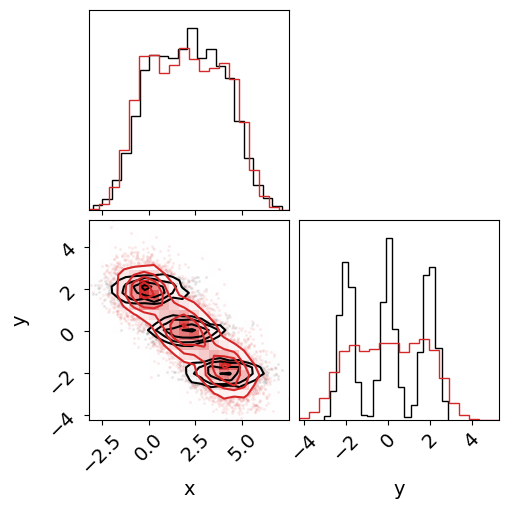

In [242]:
import corner
fig = corner.corner(E2, hist_kwargs={'density': True})
corner.corner(np.array(E2P_samples), color='C3', fig=fig, labels=['x', 'y'], hist_kwargs={'density': True})
fig.savefig('three_modes.png')
#scatter(E2P_samples[:, 0], E2P_samples[:, 1], alpha = 0.5, s = 5)

In [1]:
import pandas as pd
df = pd.read_csv('/home/nielsemb/work/repos/PBjam/pbjam/data/prior_data.csv')

In [2]:
tgtnumax = 1200
idx = (1100 < 10**df['numax']) & (10**df['numax'] < 1200) #np.argmin(abs(10**df['numax']-tgtnumax))
df.loc[idx, 'ID']

1165     KIC10732098
4005      KIC2991448
4776      KIC3854781
5349      KIC4457351
11726     KIC9026685
13556     KIC4586099
13571     KIC7510397
13577     KIC8228742
13605     KIC6529109
13627     KIC9202077
13629     KIC3633847
13630     KIC8494142
13633     KIC5021689
13640     KIC9414417
13647     KIC9697131
13648    KIC12317678
13657     KIC8554498
Name: ID, dtype: object

In [3]:
df.loc[idx, :]

,ID,numax,dnu,teff,bp_rp,eps_p,d02,alpha_p,env_height,env_width,...,H3_exp,H3_exp_err,shot,shot_err,p_L0,p_D0,DPi0,eps_g,alpha_g,d01
1165,KIC10732098,3.056376,1.790688,3.763128,0.862216,1.382435,0.778154,-3.297644,0.656435,1.980680,...,2.177809,0.135366,0.921283,0.009064,NaN,NaN,NaN,NaN,NaN,NaN
4005,KIC2991448,3.055235,1.790047,3.766115,0.873957,1.394765,0.819693,-3.481696,0.736350,1.978549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4776,KIC3854781,3.066803,1.793024,3.756256,0.889997,1.360206,0.799134,-3.536876,0.677157,2.020215,...,2.270722,0.115440,0.820708,0.009353,NaN,NaN,NaN,NaN,NaN,NaN
5349,KIC4457351,3.048223,1.789039,3.739018,0.954050,1.401078,0.826124,-3.479198,0.615360,1.939019,...,2.810768,0.150820,0.693998,0.010858,NaN,NaN,NaN,NaN,NaN,NaN
11726,KIC9026685,3.045210,1.792876,3.749582,0.903662,1.427170,0.809080,-3.550108,0.815756,2.035267,...,2.246063,0.158533,0.656699,0.011174,NaN,NaN,NaN,NaN,NaN,NaN
13556,KIC4586099,3.063642,1.787840,3.799065,0.660747,1.148833,0.711050,-2.908139,0.581869,2.207637,...,NaN,NaN,NaN,NaN,-9.393123,-9.222602,-0.296525,0.749912,-1.704824,1.441060
13571,KIC7510397,3.060874,1.792239,3.786041,0.689762,1.195512,0.793123,-2.204251,0.533208,2.075721,...,NaN,NaN,NaN,NaN,-9.400559,-9.219929,-0.297188,0.749154,-1.696817,1.428420
13577,KIC8228742,3.051929,1.789710,3.781181,0.727789,1.288050,0.747072,-2.051898,0.515566,2.308841,...,NaN,NaN,NaN,NaN,-9.400611,-9.222367,-0.305954,0.749403,-1.712668,1.423576
13605,KIC6529109,3.075724,1.782659,3.763877,0.875061,1.389206,0.783939,-3.430895,0.757525,2.019088,...,NaN,NaN,NaN,NaN,-9.393548,-9.219039,-0.297653,0.749609,-1.698186,1.425240
13627,KIC9202077,3.057267,1.764682,3.786680,0.727826,1.097364,0.685364,-2.992660,0.502984,2.226613,...,NaN,NaN,NaN,NaN,-9.398684,-9.222721,-0.297514,0.750920,-1.696947,1.437828


In [4]:
10**df.loc[idx, 'numax']

1165     1138.612160
4005     1135.624142
4776     1166.281297
5349     1117.437032
11726    1109.712061
13556    1157.821927
13571    1150.465799
13577    1127.014086
13605    1190.485182
13627    1140.950776
13629    1152.641257
13630    1137.664597
13633    1176.567943
13640    1125.243854
13647    1143.369237
13648    1176.562102
13657    1146.641791
Name: numax, dtype: float64

In [5]:
10**df.loc[idx, 'dnu']

1165     61.757289
4005     61.666197
4776     62.090372
5349     61.523234
11726    62.069244
13556    61.353639
13571    61.978220
13577    61.618306
13605    60.625954
13627    58.167759
13629    61.276989
13630    62.040968
13633    63.723771
13640    59.936120
13647    60.539146
13648    63.751932
13657    62.488578
Name: dnu, dtype: float64

In [6]:
10**df.loc[idx, 'teff']

1165     5796.0
4005     5836.0
4776     5705.0
5349     5483.0
11726    5618.0
13556    6296.0
13571    6110.0
13577    6042.0
13605    5806.0
13627    6119.0
13629    6122.0
13630    6144.0
13633    6168.0
13640    6278.0
13647    6491.0
13648    6549.0
13657    5945.0
Name: teff, dtype: float64

In [251]:
import numpy as np

In [261]:
A = np.random.uniform(1, 2, size=(100, 100))



In [263]:
%%timeit
eigvals, eigvectors = np.linalg.eig(A)

12.8 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [357]:
def covarianceMatrix(_X):
 
    weights = np.ones(_X.shape[0])
    
    W = np.diag(weights)

 
    C = _X.T@W@_X * np.sum(weights) / (np.sum(weights)**2 - np.sum(weights**2))

    return C

def scale(data, mu, std):

    scaledData = (data - mu) / std

    return scaledData


In [358]:
_E2 = scale(E2, np.mean(E2, axis=0), np.std(E2, axis=0))



array([1., 1.])

In [327]:
_C = covarianceMatrix(E2 - np.mean(E2, axis=0))

In [367]:
cov = np.cov(_E2.T)
corr = np.corrcoef(_E2.T)

In [368]:
cov_eigval, cov_eigvec = np.linalg.eig(cov)

In [369]:
corr_eigval, corr_eigvec = np.linalg.eig(corr)

In [370]:
 cov

array([[ 1.00033344, -0.83675098],
       [-0.83675098,  1.00033344]])

In [371]:
corr

array([[ 1.        , -0.83647206],
       [-0.83647206,  1.        ]])

[autoreload of jaxlib.xla_client failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jaxlib/xla_client.py", line 238, in <module>
    PrimitiveType.F8E4M3FN: np.dtype(float8_e4m3fn),
AttributeError: type object 'jaxlib.xla_extension.PrimitiveType' has no attribute 'F8E4M3FN'
]
[autoreload of jaxlib.mlir.ir failed: Traceback 

[autoreload of jax.tree_util failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/tree_util.py", line 41, in <module>
    from jax._src.tree_util import (
ImportError: cannot import name 'register_pytree_with_keys' from 'jax._src.tree_util' (/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/tree_util.py)
]
[auto

[autoreload of jax._src.profiler failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/profiler.py", line 31, in <module>
    from jax._src import xla_bridge
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/xla_bridge.py", line 58, in <module>
    flags.DEFINE_string(
  File "/home/nielsemb/.local/l

[autoreload of jax.interpreters.mlir failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/interpreters/mlir.py", line 15, in <module>
    from jax._src.interpreters.mlir import (
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py", line 37, in <module>
    from jax._src import shardin

[autoreload of jax._src.lax.lax failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py", line 48, in <module>
    from jax._src.interpreters import ad
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/interpreters/ad.py", line 23, in <module>
    from jax._src.interpreters import partial_ev

[autoreload of jax._src.api failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/api.py", line 40, in <module>
    from jax._src.tree_util import (
ImportError: cannot import name 'keystr' from 'jax._src.tree_util' (/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/tree_util.py)
]
[autoreload of jax._src.sh

[autoreload of jax._src.state.types failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    update_instances(old, new)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]
[autoreload of jax._src.state.primitives failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packag

[autoreload of jax._src.lax.parallel failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/lax/parallel.py", line 30, in <module>
    from jax._src import sharding_impls
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/sharding_impls.py", line 28, in <module>
    from jax._src import mesh as mesh_li

[autoreload of jax.experimental.maps failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/experimental/maps.py", line 15, in <module>
    from jax._src.maps import (
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/maps.py", line 30, in <module>
    from jax._src import mesh as mesh_lib
  File "/home/ni

[autoreload of jax.sharding failed: Traceback (most recent call last):
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/nielsemb/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/sharding.py", line 19, in <module>
    from jax._src.sharding_impls import (
  File "/home/nielsemb/.local/lib/python3.10/site-packages/jax/_src/sharding_impls.py", line 28, in <module>
    from jax._src import mesh as mesh_lib
  File "/home/